In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit

In [2]:
t = 1
T = 2
r = 0.03 
sigma = 0.25

S = 100
Y = 10

## Analytical Solution

## <center> $V = e^{-r  T}\frac{S_{0}}{r T} \cdot (e^{r T} - 1)$ </center>

In [3]:
Y1 = 10
asian = np.exp(-r * t) * (S / r * t) * (np.exp(r * t) - 1)
print("Asian Price: ", Y1 + asian)

Asian Price:  108.51488817163968


In [4]:
def asian_price(S, r, t):
    
    return np.exp(-r * t) * (S / r * t) * (np.exp(r * t) - 1)

## Monte Carlo Solution

In [20]:
@jit(nopython = True)
def asian_monte_carlo():
    """
    Computes the price of vanilla asian option using monte carlo methods
    Implements numba for speed
    """
    
    r = 0.03
    sigma = 0.25
    
    t = 1
    T = 2
    
    Y1 = 10
    S = 100
    
    myData = []
    N = np.array([100, 1000, 10000])
    
    for n in N:
    
        U = np.linspace(1, 2, n)
        dt = U[1] - U[0]

        Y2 = np.zeros(n)

        for i in range(n):

            temp = np.zeros(n)        
            rv = np.random.normal(0, 1, n)

            B = np.cumsum(rv * np.sqrt(dt))
            temp = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

            integral = 10

            for k in range(n):

                integral += temp[k] * dt

            Y2[i] = integral
            
        myData.append(Y2)
        
    return myData

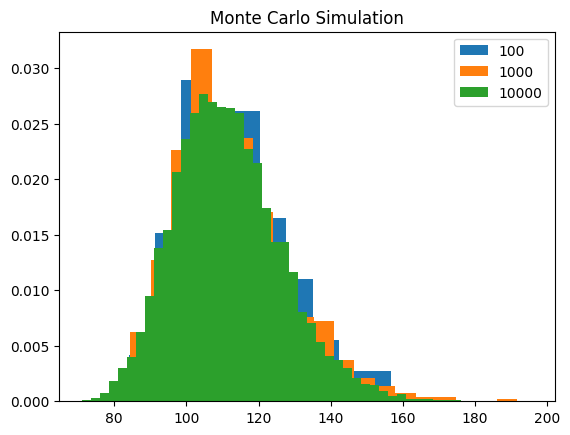

In [21]:
arr = asian_monte_carlo()

plt.hist(arr[0], bins = 10, density = True, label = "100")
plt.hist(arr[1], bins = 20, density = True, label = "1000")
plt.hist(arr[2], bins = 50, density = True, label = "10000")
plt.title("Monte Carlo Simulation")
plt.legend(loc = 'best')
plt.show()

## Convergence Rate

In [22]:
for i in range(len(arr)):
    print("Monte Carlo Price: ", np.exp(-r * t) * np.mean(arr[i]))

Monte Carlo Price:  113.13767982722955
Monte Carlo Price:  112.23337810271481
Monte Carlo Price:  111.5973967838995


## Delta Hedging

#### Delta hedging does work for exotic options such as Asian options. The price of the asian option has a sensitivity to changes in the underlying price, which is delta exposure. The delta does not depend on changes to the underlying which makes the hedge easier. 

## <center> $\Delta = e^{-r  T}\frac{1}{r T} \cdot (e^{r T} - 1)$ </center>

In [8]:
N = 1000
dt = 1 / N
rv = np.random.normal(0, 1, N)

B = np.cumsum(rv * np.sqrt(dt))
stock_process = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

## Analytical Solution

In [9]:
delta = np.exp(-r * t) * (1 / r * t) * (np.exp(r * t) - 1)
print("Asian Delta: ", delta)

Asian Delta:  0.9851488817163967


In [10]:
tau = np.linspace(0, 1, N)
deltas = np.zeros(N)
prices = np.zeros(N)
time = tau[::-1]

index = 0
for t in time:
    
    prices[index] = asian_price(100, r, t)
    deltas[index] = np.exp(-r * t) * (1 / r * t) * (np.exp(r * t) - 1)
    index += 1 

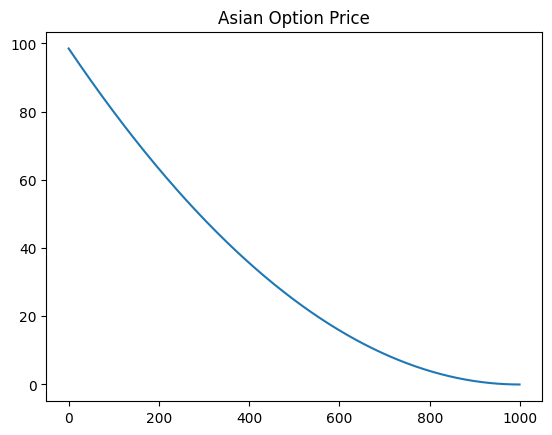

In [11]:
plt.plot(prices)
plt.title("Asian Option Price")
plt.show()

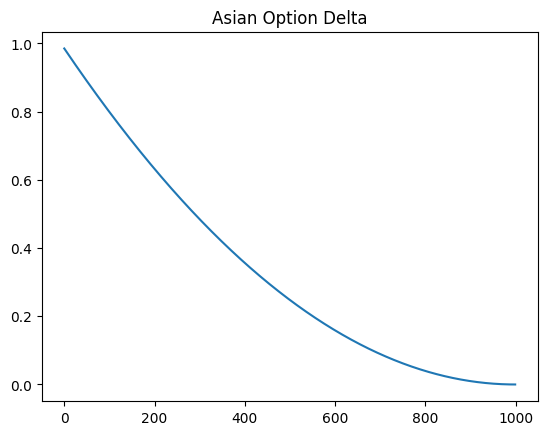

In [12]:
plt.plot(deltas)
plt.title("Asian Option Delta")
plt.show()

## Self Financing Portfolio

In [13]:
pi_process = np.zeros(N)
pi_process[0] = prices[0]
print("Initial Price: ", prices[0])

Initial Price:  98.51488817163968


In [14]:
y = np.zeros(N)
y[0] = prices[0] - (deltas[0] * stock_process[0])

for i in range(1, N):
    
    pi_process[i] = (deltas[i] * stock_process[i]) + (y[i - 1] * np.exp(-r * dt))
    y[i] = prices[i] - (deltas[i] * stock_process[i])

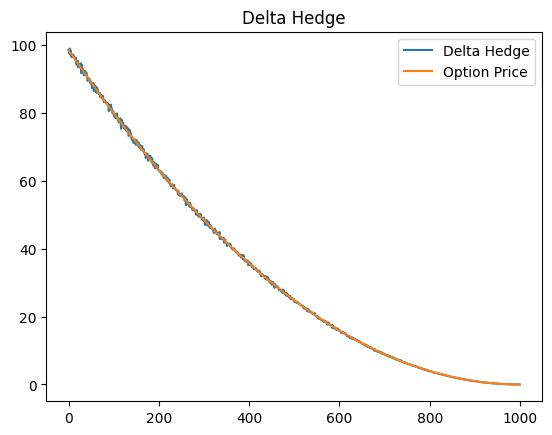

In [15]:
plt.plot(pi_process, label = "Delta Hedge")
plt.plot(prices, label = "Option Price")
plt.title("Delta Hedge")
plt.legend(loc = 'best')
plt.show()

In [16]:
print("Option Price: ", prices[-1])
print("Hedging Process: ", pi_process[-1])

Option Price:  0.0
Hedging Process:  -4.1612243315548686e-05


## Asian Call